In [43]:
import pandas as pd
import numpy as np
import datetime

# plot imports
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


# moddeling and forecasting
from xgboost import XGBRegressor


In [44]:
df = pd.read_csv("../measurements")

df.head()

,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea,ID,Week,Date
229,Satine,RGB_1.png,Depth_1.png,2.6,0.14,8.2,12.0,80.6,1,2021-W1,2021-01-04
362,Satine,RGB_2.png,Depth_2.png,2.1,0.10,8.5,8.2,67.4,2,2021-W1,2021-01-04
258,Satine,RGB_3.png,Depth_3.png,2.0,0.09,7.5,9.5,65.0,3,2021-W1,2021-01-04
263,Satine,RGB_4.png,Depth_4.png,2.7,0.13,6.0,10.6,78.7,4,2021-W1,2021-01-04
224,Lugano,RGB_5.png,Depth_5.png,2.3,0.11,8.3,9.8,73.9,5,2021-W1,2021-01-04


In [45]:
df["Date"].unique()

array(['2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
       '2021-02-01', '2021-02-08', '2021-02-15'], dtype=object)

In [46]:
def prepare_dataframe(df, variety):
    #%Y-%m-%d
    df["date_time"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.head()
    df = df.loc(axis=1)["date_time","Variety", "FreshWeightShoot", "DryWeightShoot", "Height", "Diameter", "LeafArea","ID"]


    df = df.groupby(by='date_time').mean()

    # # changed index to date
    # df = df.set_index('date_time')
    # df = df.asfreq('H')

    # df = df.loc[df["Variety"] == variety]
    return df

In [47]:
df = prepare_dataframe(df, "Satine")

df.head()

,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea,ID
date_time,,,,,,
2021-01-04,4.952727,0.425818,7.078182,15.094545,138.087273,28.0
2021-01-11,20.928333,1.440167,7.241667,17.868333,481.061667,85.5
2021-01-18,53.932812,2.764219,10.714063,20.676562,1104.575000,147.5
2021-01-25,91.297959,4.516327,11.877551,22.587755,1699.681633,204.0
2021-02-01,158.300000,7.563182,15.463636,26.215909,2808.152273,250.5


In [48]:
def split_data(train_weeks, validation_weeks):
    # Raises exception when te requested amount of weeks is to big
    if train_weeks + validation_weeks > 6:
        raise Exception("To many weeks!")

    # Calculate datetime from weeks
    start_date = datetime.datetime(2021,1,4)
    end_train_date = start_date + datetime.timedelta(weeks=train_weeks -1 )
    end_validation_date = end_train_date + datetime.timedelta(weeks=validation_weeks)

    #format datetime to %Y-%m-%d
    end_train_date = end_train_date.strftime(format='%Y-%m-%d')
    end_validation_date = end_validation_date.strftime(format='%Y-%m-%d')


    data_train = df.loc[: end_train_date, :]
    data_val   = df.loc[end_train_date:end_validation_date, :]
    data_test  = df.loc[end_validation_date:, :]

    return data_train, data_val, data_test, end_train_date, end_validation_date



In [49]:
data_train, data_val, data_test,end_train_date, end_validation_date  = split_data(4,2)

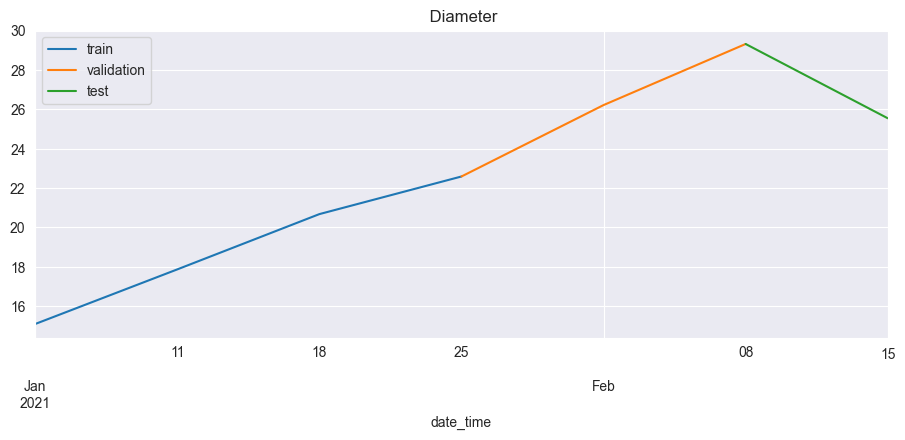

In [50]:
data_val_mean = data_val.groupby('date_time').mean()
data_test_mean = data_test.groupby('date_time').mean()
data_train_mean = data_train.groupby('date_time').mean()

fig, ax = plt.subplots(figsize=(11, 4))
data_train_mean['Diameter'].plot(ax=ax, label='train')
data_val_mean['Diameter'].plot(ax=ax, label='validation')
data_test_mean['Diameter'].plot(ax=ax, label='test')
ax.set_title(' Diameter')
ax.legend();

XGBoost

In [51]:
def create_forecaster(lags):
    forecaster = ForecasterAutoreg(
        regressor = XGBRegressor(random_state=123),
        lags = lags
    )
    return forecaster

forecaster = create_forecaster(5)

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...) 
Lags: [1 2 3 4 5] 
Transformer for y: None 
Transformer for exog: None 
Window size: 5 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range

In [52]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [3,10, [1, 2, 3,20]]


results_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = df.loc[:end_validation_date, 'Diameter'], # Train and validation data
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = 11,
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(data_train)), # Model is trained with trainign data
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

Number of models compared: 36.


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]C:\school\minor-ai\lettuce-cnn\lib\site-packages\skforecast\utils\utils.py:522: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\school\minor-ai\lettuce-cnn\lib\site-packages\skforecast\utils\utils.py:579: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\school\minor-ai\lettuce-cnn\lib\site-packages\skforecast\utils\utils.py:522: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\school\minor-ai\lettuce-cnn\lib\site-packages\skforecast\utils\utils.py:579: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(

loop param_grid:  17%|██████▏                              | 2/12

ValueError: `initial_train_size` must be greater than forecaster's window_size (10).

In [ ]:
results_grid.head(10)

In [ ]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = df['Diameter'],
    initial_train_size = len(df.loc[:end_validation_date]),
    fixed_train_size   = False,
    steps      = 10,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Backtest error: {metric}")

In [ ]:
print(backtesting_forecaster.__doc__)

In [ ]:
predictions.head()

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))
data_test['Diameter'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();